<a href="https://colab.research.google.com/github/nugomes2019/00-colab/blob/main/timeseries_markov_regime_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Regime Analysis

This notebook explores time series regime analysis in python. Markov Switching Autoregressions (MS-AR) are used to detect and classify underlying states. A Random Forest Classifier is used to predict the next regime.

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

import seaborn as sns
import numpy as np
import yfinance as yf
import pandas as pd
import random

import numpy as np
import scipy.stats as scs

Importing our S&P 500 dataset from Yahoo Finance, using the yfinance library. Displaying the data in a dataframe.

In [ ]:
df = yf.download('^GSPC', start="2000-01-01", end="2022-09-01", interval="1d")
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


----------------------------------------------------------------
Plotting the adjusted close price to visualize the time series.

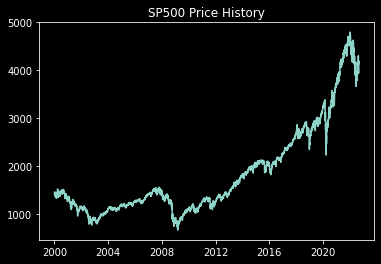

In [ ]:
plt.title(f'SP500 Price History')
plt.plot(
    list(i for i in df.index),
    list(i[4] for i in df.values))
plt.grid(False)

------------------------
Creating and plotting price returns. Price returns are just the percentage change in price over 1 day.

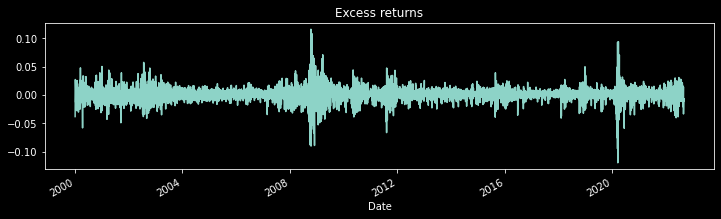

In [ ]:
df['r-1'] = df['Adj Close'].pct_change().dropna()

ex_ret = df['r-1']
ex_ret.plot(title='Excess returns', figsize=(12, 3), grid=False)

---------------------
Fitting the Markov regression model and viewing a summary output.

In [ ]:
# Fit the model
mod_kns = sm.tsa.MarkovRegression(ex_ret.dropna(), k_regimes=2, trend='n', switching_variance=True)
res_kns = mod_kns.fit()
# res_kns.summary()

-----------------
Viewing the smoothed probabilistic outputs from the fitted model. These are the models regime classifications on the dataset fitted. These probabilities are then plotted.

In [ ]:
res_kns.smoothed_marginal_probabilities.head()

,0,1
Date,,
2000-01-04,0.000002,0.999998
2000-01-05,0.003388,0.996612
2000-01-06,0.003570,0.996430
2000-01-07,0.000668,0.999332
2000-01-10,0.014216,0.985784


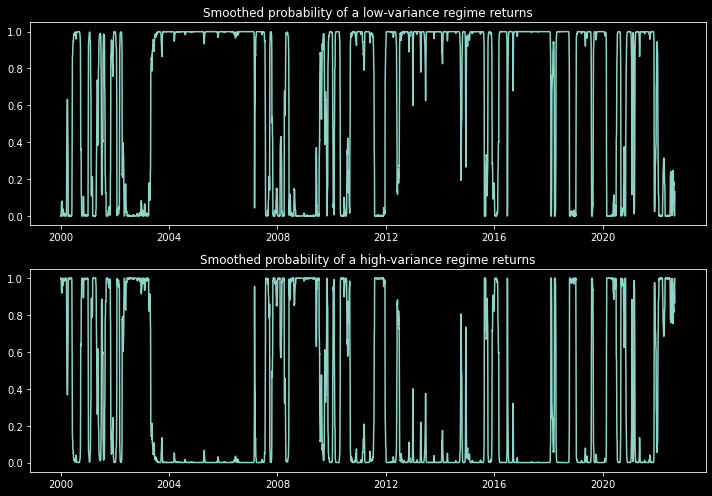

In [ ]:
fig, axes = plt.subplots(2, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.grid(False)
ax.set(title='Smoothed probability of a low-variance regime returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a high-variance regime returns')
fig.tight_layout()
ax.grid(False)

----------
Encoding regimes into binary states. 

0 --> low variance regime returns

1 --> high variance regime returns

In [ ]:
low_var = list(res_kns.smoothed_marginal_probabilities[0])
high_var = list(res_kns.smoothed_marginal_probabilities[1])

regime_list = []
for i in range(0, len(low_var)):
    if low_var[i] > high_var[i]:
        regime_list.append(0)
    else:
        regime_list.append(1)

In [ ]:
regime_df = pd.DataFrame()
regime_df['regimes'] = regime_list

------
Plotting the encoded states on the adjusted close price series of the S&P 500, this gives a visual representation of the models regime classifications in time and price space.

Text(0.5, 0.98, 'Historical SP500 regimes')

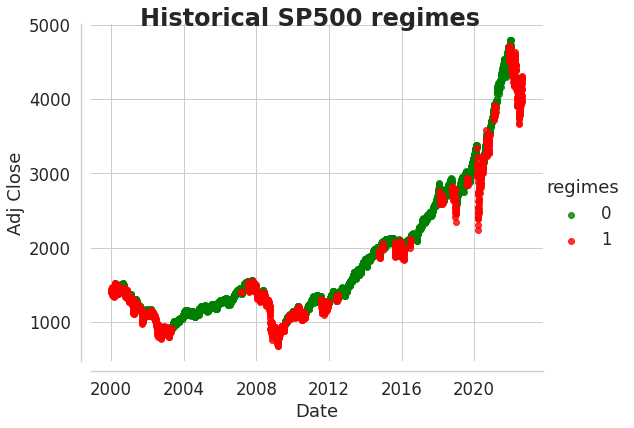

In [ ]:
sns.set(font_scale=1.5)
df = df.iloc[len(df)-len(regime_list):]
regimes = (pd.DataFrame(regime_list, columns=['regimes'], index=df.index)
          .join(df, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
regimes.head()

import warnings
warnings.filterwarnings("ignore")
colors = 'green', 'red', 'yellow'
sns.set_style("whitegrid")
order = [0, 1]
fg = sns.FacetGrid(data=regimes, hue='regimes', hue_order=order,
                   palette=colors, aspect=1.31, height=6)
fg.map(plt.scatter, 'Date', "Adj Close", alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SP500 regimes', fontsize=24, fontweight='demi')